# **Markov chains Mini-project**



In [6]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
np.random.seed(42)
from utils import *

## **MCMC simulation**

In [7]:
N = 5
random_board = FastBoard(N, None)
print(f"Random board N=5:")
print(random_board.board)
print("With cost:", random_board.current_energy)


steps = 100000
random_board.step(0.5, n=steps)
print(f"The same board after {steps} iterations:")
print(random_board.board)
print("With cost:", random_board.current_energy)



Random board N=5:
[[3 4 2 4 4]
 [1 2 2 2 4]
 [3 2 4 1 3]
 [1 3 4 0 3]
 [1 4 3 0 0]]
With cost: 67
The same board after 100000 iterations:
[[2 2 0 4 1]
 [0 4 0 3 1]
 [1 3 1 3 4]
 [1 3 4 0 0]
 [4 2 0 2 3]]
With cost: 39


## **Further tasks and questions**

### Question 1 

100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


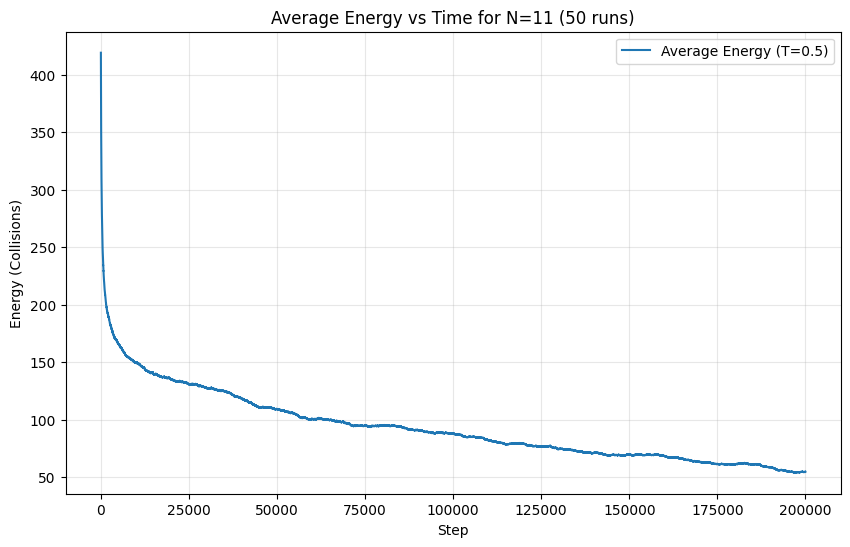

array([418.92, 417.5 , 415.94, ...,  54.92,  54.94,  54.94],
      shape=(200001,))

In [8]:
average_energy_fixed_T(N=11, steps=200000, runs=50, temperature=0.5)

### Question 2

In [9]:
# Finding the bests temperature and cooling rate for each cooling method.
# tune_all(N=11, steps=200000, trials=50)

Simulating → Constant (T=0.7)


100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


Simulating → Linear


100%|██████████| 50/50 [01:30<00:00,  1.80s/it]


Simulating → Polynomial (power=2)


100%|██████████| 50/50 [01:29<00:00,  1.78s/it]


Simulating → Exponential


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


Simulating → piecewise constant(as seen in course)


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


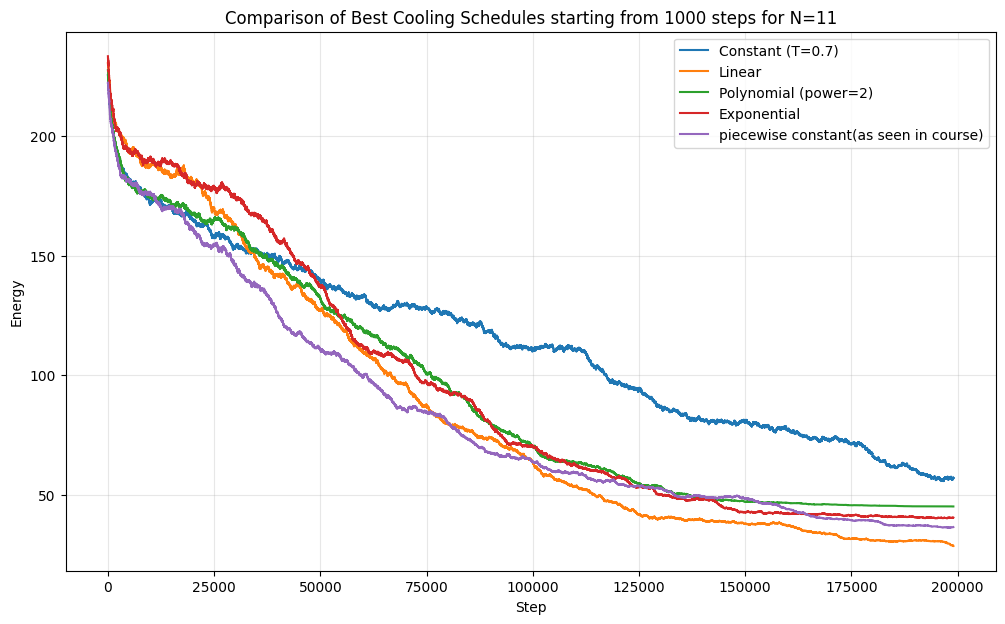

In [10]:
np.random.seed(21)
plot_multiple_schedules(N=11, steps=200000, runs=50)



### Question 3

Testing N sizes:   6%|▌         | 1/17 [03:26<55:03, 206.45s/it]

  N=3, Best Energy Found: 13 (method: constant)


Testing N sizes:  12%|█▏        | 2/17 [06:56<52:05, 208.39s/it]

  N=4, Best Energy Found: 23 (method: constant)


Testing N sizes:  18%|█▊        | 3/17 [10:30<49:15, 211.13s/it]

  N=5, Best Energy Found: 34 (method: constant)


Testing N sizes:  24%|██▎       | 4/17 [14:08<46:17, 213.67s/it]

  N=6, Best Energy Found: 47 (method: linear)


Testing N sizes:  29%|██▉       | 5/17 [17:46<43:02, 215.21s/it]

  N=7, Best Energy Found: 55 (method: constant)


Testing N sizes:  35%|███▌      | 6/17 [21:23<39:36, 216.01s/it]

  N=8, Best Energy Found: 56 (method: constant)


Testing N sizes:  41%|████      | 7/17 [25:05<36:18, 217.80s/it]

  N=9, Best Energy Found: 57 (method: constant)


Testing N sizes:  47%|████▋     | 8/17 [28:46<32:49, 218.83s/it]

  N=10, Best Energy Found: 39 (method: linear)


Testing N sizes:  53%|█████▎    | 9/17 [28:50<20:15, 151.89s/it]

Perfect solution found for N = 11 with method constant: [(0, 0, 8), (0, 1, 6), (0, 2, 4), (0, 3, 2), (0, 4, 0), (0, 5, 9), (0, 6, 7), (0, 7, 5), (0, 8, 3), (0, 9, 1), (0, 10, 10), (1, 0, 2), (1, 1, 0), (1, 2, 9), (1, 3, 7), (1, 4, 5), (1, 5, 3), (1, 6, 1), (1, 7, 10), (1, 8, 8), (1, 9, 6), (1, 10, 4), (2, 0, 7), (2, 1, 5), (2, 2, 3), (2, 3, 1), (2, 4, 10), (2, 5, 8), (2, 6, 6), (2, 7, 4), (2, 8, 2), (2, 9, 0), (2, 10, 9), (3, 0, 1), (3, 1, 10), (3, 2, 8), (3, 3, 6), (3, 4, 4), (3, 5, 2), (3, 6, 0), (3, 7, 9), (3, 8, 7), (3, 9, 5), (3, 10, 3), (4, 0, 6), (4, 1, 4), (4, 2, 2), (4, 3, 0), (4, 4, 9), (4, 5, 7), (4, 6, 5), (4, 7, 3), (4, 8, 1), (4, 9, 10), (4, 10, 8), (5, 0, 0), (5, 1, 9), (5, 2, 7), (5, 3, 5), (5, 4, 3), (5, 5, 1), (5, 6, 10), (5, 7, 8), (5, 8, 6), (5, 9, 4), (5, 10, 2), (6, 0, 5), (6, 1, 3), (6, 2, 1), (6, 3, 10), (6, 4, 8), (6, 5, 6), (6, 6, 4), (6, 7, 2), (6, 8, 0), (6, 9, 9), (6, 10, 7), (7, 0, 10), (7, 1, 8), (7, 2, 6), (7, 3, 4), (7, 4, 2), (7, 5, 0), (7, 6, 9), (7, 

Testing N sizes:  59%|█████▉    | 10/17 [32:36<20:21, 174.53s/it]

  N=12, Best Energy Found: 25 (method: linear)


Testing N sizes:  65%|██████▍   | 11/17 [35:51<18:05, 180.85s/it]

Perfect solution found for N = 13 with method batch: [(0, 0, 4), (0, 1, 10), (0, 2, 3), (0, 3, 9), (0, 4, 2), (0, 5, 8), (0, 6, 1), (0, 7, 7), (0, 8, 0), (0, 9, 6), (0, 10, 12), (0, 11, 5), (0, 12, 11), (1, 0, 6), (1, 1, 12), (1, 2, 5), (1, 3, 11), (1, 4, 4), (1, 5, 10), (1, 6, 3), (1, 7, 9), (1, 8, 2), (1, 9, 8), (1, 10, 1), (1, 11, 7), (1, 12, 0), (2, 0, 8), (2, 1, 1), (2, 2, 7), (2, 3, 0), (2, 4, 6), (2, 5, 12), (2, 6, 5), (2, 7, 11), (2, 8, 4), (2, 9, 10), (2, 10, 3), (2, 11, 9), (2, 12, 2), (3, 0, 10), (3, 1, 3), (3, 2, 9), (3, 3, 2), (3, 4, 8), (3, 5, 1), (3, 6, 7), (3, 7, 0), (3, 8, 6), (3, 9, 12), (3, 10, 5), (3, 11, 11), (3, 12, 4), (4, 0, 12), (4, 1, 5), (4, 2, 11), (4, 3, 4), (4, 4, 10), (4, 5, 3), (4, 6, 9), (4, 7, 2), (4, 8, 8), (4, 9, 1), (4, 10, 7), (4, 11, 0), (4, 12, 6), (5, 0, 1), (5, 1, 7), (5, 2, 0), (5, 3, 6), (5, 4, 12), (5, 5, 5), (5, 6, 11), (5, 7, 4), (5, 8, 10), (5, 9, 3), (5, 10, 9), (5, 11, 2), (5, 12, 8), (6, 0, 3), (6, 1, 9), (6, 2, 2), (6, 3, 8), (6, 4, 1

Testing N sizes:  71%|███████   | 12/17 [39:42<16:20, 196.05s/it]

  N=14, Best Energy Found: 91 (method: polynomial)


Testing N sizes:  76%|███████▋  | 13/17 [43:33<13:47, 206.89s/it]

  N=15, Best Energy Found: 186 (method: polynomial)


Testing N sizes:  82%|████████▏ | 14/17 [47:25<10:43, 214.47s/it]

  N=16, Best Energy Found: 220 (method: batch)


Testing N sizes:  88%|████████▊ | 15/17 [51:22<07:22, 221.12s/it]

  N=17, Best Energy Found: 248 (method: polynomial)


Testing N sizes:  94%|█████████▍| 16/17 [55:20<03:46, 226.07s/it]

  N=18, Best Energy Found: 279 (method: polynomial)


Testing N sizes: 100%|██████████| 17/17 [59:16<00:00, 209.21s/it]

  N=19, Best Energy Found: 312 (method: polynomial)
N=3: Minimum energy = 13 (method: constant)
N=4: Minimum energy = 23 (method: constant)
N=5: Minimum energy = 34 (method: constant)
N=6: Minimum energy = 47 (method: linear)
N=7: Minimum energy = 55 (method: constant)
N=8: Minimum energy = 56 (method: constant)
N=9: Minimum energy = 57 (method: constant)
N=10: Minimum energy = 39 (method: linear)
N=11: Minimum energy = 0 (method: constant)
N=12: Minimum energy = 25 (method: linear)
N=13: Minimum energy = 0 (method: batch)
N=14: Minimum energy = 91 (method: polynomial)
N=15: Minimum energy = 186 (method: polynomial)
N=16: Minimum energy = 220 (method: batch)
N=17: Minimum energy = 248 (method: polynomial)
N=18: Minimum energy = 279 (method: polynomial)
N=19: Minimum energy = 312 (method: polynomial)

Perfect solutions found for N = [11, 13]


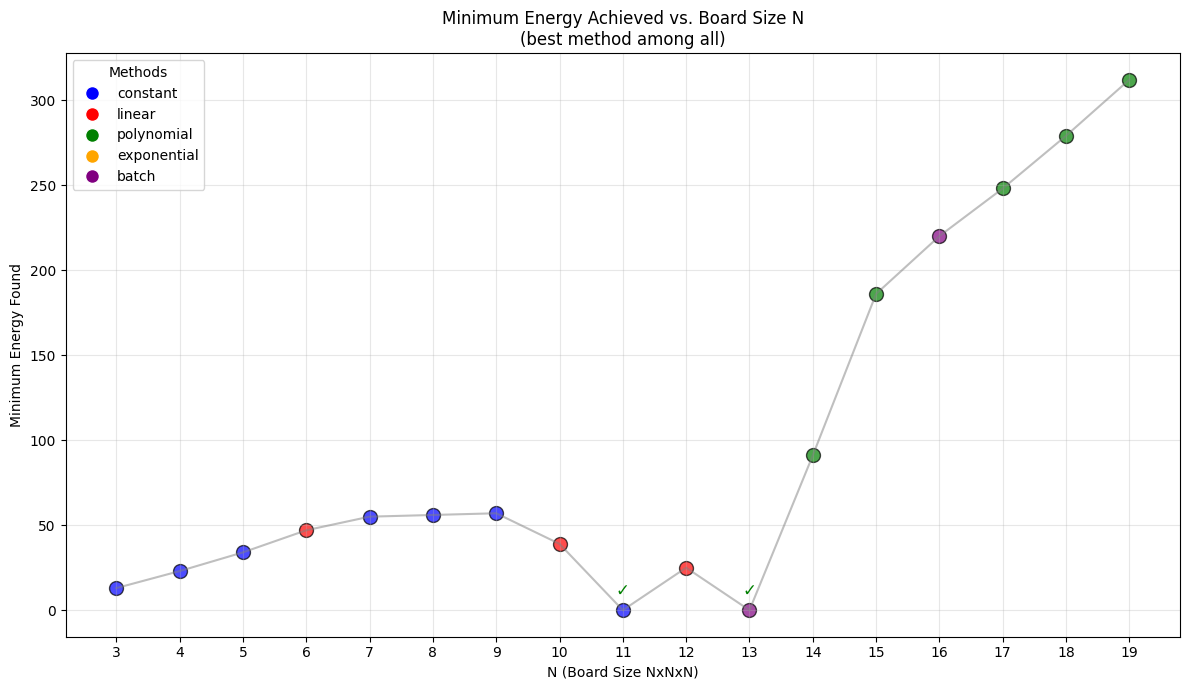

In [11]:
n_values = range(3,20)
steps = 500000
repeats = 10
np.random.seed(32)
results = compare_N_all_methods(n_values, steps, repeats)